In [1]:
import sys
from pathlib import Path

import rich
import yaml

run_id = "st1fu8ls"
run_dir = Path(
    f"/net/csefiles/coc-fung-cluster/nima/shared/experiment-data/lltrainer/{run_id}/"
)
assert (
    run_dir.exists() and run_dir.is_dir()
), f"run_dir: {run_dir} does not exist or is not a directory"
print(run_dir)


def _load_python_path(run_dir: Path):
    if (hparams_path := next((run_dir / "log").glob("**/hparams.yaml"), None)) is None:
        raise FileNotFoundError(f"Could not find hparams.yaml in {run_dir}")

    config = yaml.unsafe_load(hparams_path.read_text())
    global python_path
    python_path = config.get("environment", {}).get("python_path", [])

    # Find the ll_snapshot if it exists
    if (
        snapshot_path := next(
            (
                path
                for path in config.get("environment", {}).get("python_path", [])
                if path.stem == "ll_snapshot" and path.is_dir()
            ),
            None,
        )
    ) is None:
        return

    # Add it to the current python path
    snapshot_path = str(snapshot_path.absolute())
    print(f"Added {snapshot_path} to the beginning of PYTHONPATH")
    sys.path.insert(0, snapshot_path)


USE_SNAPSHOT = False
if USE_SNAPSHOT:
    _load_python_path(run_dir)

/net/csefiles/coc-fung-cluster/nima/shared/experiment-data/lltrainer/st1fu8ls


In [2]:
import os

os.environ["LL_DISABLE_TYPECHECKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"


import nshtrainer.ll as ll
import torch

ll.pretty()

torch.no_grad().__enter__()
torch.inference_mode().__enter__()

TensorBoard/TensorBoardX not found. Disabling TensorBoardLogger. Please install TensorBoard with `pip install tensorboard` or TensorBoardX with `pip install tensorboardx` to enable TensorBoard logging.


In [3]:
from jmppeft.tasks.finetune.base import FinetuneMatBenchDiscoveryIS2REDatasetConfig

dataset_config = FinetuneMatBenchDiscoveryIS2REDatasetConfig(
    # sample_n=DatasetSampleNConfig(sample_n=16, seed=42)
)
print(dataset_config)

dataset_og = dataset_config.create_dataset()
dataset_og, len(dataset_og)

[18:38:29] CRITICAL Type checking is disabled due to the environment variable                       ]8;id=892021;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/ll/src/ll/typecheck.py\typecheck.py]8;;\:]8;id=392407;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/ll/src/ll/typecheck.py#55\55]8;;\
                    LL_DISABLE_TYPECHECKING.                                                                       

[18:38:30] INFO     PyTorch version 2.2.2 available.                                                   ]8;id=41220;file:///net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/datasets/config.py\config.py]8;;\:]8;id=3805;file:///net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/datasets/config.py#58\58]8;;\


Loading 'wbm_summary' from cached file at '/nethome/nsg6/.cache/matbench-discovery/1.0.0/wbm/2023-12-13-wbm-summary.csv.gz'


(<jmppeft.datasets.mpd_is2re.MatBenchDiscoveryIS2REDataset at 0x7f02256efc10>,
 256963)

In [4]:
run_id = "9ruj4euu"
ckpt_path = run_dir / "checkpoint" / "last.ckpt"
# If the file is a symlink, get the target
if ckpt_path.is_symlink():
    print(f"Symlink found {ckpt_path} => {ckpt_path.resolve()}")
    ckpt_path = ckpt_path.resolve()

ckpt_path

Symlink found /net/csefiles/coc-fung-cluster/nima/shared/experiment-data/lltrainer/st1fu8ls/checkpoint/last.ckpt => /net/csefiles/coc-fung-cluster/nima/shared/experiment-data/lltrainer/st1fu8ls/checkpoint/epoch=40-step=464079-val_matbench_discovery_force_mae=0.030521517619490623.ckpt


Path('/net/csefiles/coc-fung-cluster/nima/shared/experiment-data/lltrainer/st1fu8ls/checkpoint/epoch=40-step=464079-val_matbench_discovery_force_mae=0.030521517619490623.ckpt')

In [5]:
from jmppeft.tasks.finetune import matbench_discovery as M


def _update_dataset_(dataset_config):
    energy_column_mapping = {}
    if (energy_column := dataset_config.pop("energy_column", None)) is not None:
        energy_column_mapping["y"] = energy_column
    if (
        relaxed_energy_column := dataset_config.pop("relaxed_energy_column", None)
    ) is not None:
        energy_column_mapping["y_relaxed"] = relaxed_energy_column
    dataset_config["energy_column_mapping"] = energy_column_mapping


hparams = None
if not USE_SNAPSHOT:
    hparams = torch.load(ckpt_path)["hyper_parameters"]
    _update_dataset_(hparams["train_dataset"])
    _update_dataset_(hparams["val_dataset"])
    _update_dataset_(hparams["test_dataset"])

    from jmppeft.tasks.finetune.base import Cutoffs, MaxNeighbors

    hparams["max_neighbors"] = MaxNeighbors.from_goc_base_proportions(15).model_dump()
    hparams["cutoffs"] = Cutoffs.from_constant(8.0).model_dump()

default_dtype = torch.float32
model = M.MatbenchDiscoveryModel.load_checkpoint(
    ckpt_path,
    hparams=hparams,
    map_location="cuda",
)
model = model.to(default_dtype)
model

[18:39:00] CRITICAL Using regular backbone                                                              ]8;id=336197;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py\base.py]8;;\:]8;id=800487;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py#605\605]8;;\

Unrecognized arguments:  dict_keys(['name', 'learnable_rbf', 'learnable_rbf_stds', 'unique_basis_per_layer', 'dropout', 'edge_dropout', 'ln_per_layer', 'scale_factor_to_ln'])


           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=260667;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=331768;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

[18:39:01] INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=503604;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=277802;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=66048;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=535771;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=974986;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=234638;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=127718;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=114372;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=536029;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=330684;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=459647;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=410063;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

[18:39:11] CRITICAL Constructed backbone with dlora=None                                                ]8;id=367730;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py\base.py]8;;\:]8;id=337616;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py#616\616]8;;\

           INFO     Registered 12 shared parameters                                         ]8;id=596455;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/ll/src/ll/model/modules/shared_parameters.py\shared_parameters.py]8;;\:]8;id=416530;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/ll/src/ll/model/modules/shared_parameters.py#72\72]8;;\

           INFO     List of ignored parameters: []                                                      ]8;id=510456;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py\base.py]8;;\:]8;id=933762;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py#694\694]8;;\

           CRITICAL Freezing 0 parameters (0.00%) out of 222,995,835 total parameters (222,995,835      ]8;id=280518;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py\base.py]8;;\:]8;id=482681;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py#923\923]8;;\
                    trainable)                                                                                     

MatbenchDiscoveryModel(config=MatbenchDiscoveryConfig(name=mptrj-jmp_l-direct-bsz32, project=jmp_mptrj), device=cuda:0)

In [6]:
from collections import Counter

import jmppeft.modules.dataset.dataset_transform as DT
import torch.utils._pytree as tree
from lightning.fabric.utilities.apply_func import move_data_to_device
from torch_geometric.data import Batch, Data


def data_transform(data: Data):
    data = model.data_transform(data)
    data = Data.from_dict(
        tree.tree_map(
            lambda x: x.type(default_dtype)
            if torch.is_tensor(x) and torch.is_floating_point(x)
            else x,
            data.to_dict(),
        )
    )
    return data


def composition(data: Batch):
    return dict(Counter(data.atomic_numbers.tolist()))


num_items = 1024

dataset = DT.transform(dataset_og, data_transform)
dataset = DT.sample_n_transform(dataset, n=num_items, seed=42)


idx = 32
data = Batch.from_data_list([dataset[idx]])
rich.print(
    data.to_dict(),
    composition(data),
)

{
    'pos': tensor[11, 3] n=33 x∈[-4.287, 6.937] μ=1.412 σ=2.423,
    'id': ['wbm-3-72883'],
    'atomic_numbers': tensor[11] i64 x∈[50, 79] μ=62.000 σ=14.269,
    'cell': tensor[1, 3, 3] n=9 x∈[-3.509, 6.938] μ=1.065 σ=4.112 [[[6.029, 0., -3.509], [-2.037, 5.674, -3.509], 
[0., 0., 6.938]]],
    'y_formation': tensor[1] [-0.236],
    'y_formation_correction': tensor[1] [0.],
    'y_above_hull': tensor[1] [0.093],
    'natoms': tensor[1] i64 [11],
    'tags': tensor[11] i64 x∈[2, 2] μ=2.000 σ=0.,
    'fixed': tensor[11] bool all_zeros,
    'batch': tensor[11] i64 all_zeros,
    'ptr': tensor[2] i64 μ=5.500 σ=7.778 [0, 11]
}
{66: 1, 50: 6, 79: 4}

In [7]:
from jmppeft.modules.relaxer import ModelOutput, Relaxer
from matbench_discovery.energy import get_e_form_per_atom


def model_fn(data, initial_data) -> ModelOutput:
    model_out = model.forward_denormalized(data)

    energy = model_out["y"]
    forces = model_out["force"]
    stress = model_out["stress"]

    # JMP-S v2 energy is corrected_energy, i.e., DFT total energy
    # This energy is now DFT total energy, we need to convert it to formation energy per atom
    energy = get_e_form_per_atom(
        {
            "composition": composition(data),
            "energy": energy,
        }
    )
    assert isinstance(energy, torch.Tensor)

    # Add the correction factor
    if False:
        energy += initial_data.y_formation_correction.item()

    energy = energy.view(1)
    forces = forces.view(-1, 3)
    stress = stress.view(1, 3, 3) if stress.numel() == 9 else stress.view(1, 6)

    return {
        "energy": energy,
        "forces": forces,
        "stress": stress,
    }


data = move_data_to_device(data, model.device)
model_fn(data, data)

{'energy': tensor[1] cuda:0 [0.059],
 'forces': tensor[11, 3] n=33 x∈[-0.549, 0.586] μ=2.955e-05 σ=0.313 cuda:0,
 'stress': tensor[1, 3, 3] n=9 x∈[-0.123, -0.002] μ=-0.042 σ=0.059 cuda:0 [[[-0.120, -0.002, -0.002], [-0.002, -0.121, -0.003], [-0.002, -0.003, -0.123]]]}

In [8]:
from jmppeft.modules.relaxer import RelaxerConfig

config = RelaxerConfig(
    compute_stress=True,
    stress_weight=0.1,
    optimizer="FIRE",
    fmax=0.05,
    ase_filter="exp",
)
relaxer = Relaxer(
    config=config,
    model=model_fn,
    collate_fn=model.collate_fn,
    device=model.device,
)
rich.print(data.y_formation)
relax_out = relaxer.relax(data)
# rich.print(relax_out)

energy = relax_out.atoms.get_total_energy()
rich.print(energy, data.y_formation)

tensor[1] cuda:0 [-0.236]

      Step     Time          Energy          fmax
FIRE:    0 18:39:15        0.059408        2.912496
FIRE:    1 18:39:15       -0.110580        1.408013
FIRE:    2 18:39:15       -0.156538        0.397323
FIRE:    3 18:39:15       -0.157652        0.402703
FIRE:    4 18:39:15       -0.158834        0.397292
FIRE:    5 18:39:15       -0.160425        0.396143
FIRE:    6 18:39:15       -0.162838        0.393564
FIRE:    7 18:39:15       -0.164743        0.390913
FIRE:    8 18:39:16       -0.167175        0.396013
FIRE:    9 18:39:16       -0.168968        0.393108
FIRE:   10 18:39:16       -0.170767        0.391079
FIRE:   11 18:39:16       -0.173187        0.390507
FIRE:   12 18:39:16       -0.175462        0.386544
FIRE:   13 18:39:16       -0.177175        0.387087
FIRE:   14 18:39:16       -0.177878        0.402735
FIRE:   15 18:39:16       -0.181540        0.397548
FIRE:   16 18:39:16       -0.186152        0.387566
FIRE:   17 18:39:16       -0.193370        0.376286
FIRE:   18 18:

-0.25627970695495605 tensor[1] cuda:0 [-0.236]

In [9]:
from collections import defaultdict

import numpy as np
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

config = RelaxerConfig(
    compute_stress=True,
    stress_weight=0.1,
    optimizer="FIRE",
    # fmax=0.01,
    # ase_filter="frechet",
    fmax=0.05,
    ase_filter="exp",
    # ase_filter="frechet",
)
relaxer = Relaxer(
    config=config,
    model=model_fn,
    collate_fn=model.collate_fn,
    device=model.device,
)

dl = DataLoader(
    dataset,
    batch_size=1,
    collate_fn=model.collate_fn,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

preds_targets = defaultdict[str, list[tuple[float, float]]](lambda: [])

for data in tqdm(dl, total=len(dl)):
    data = move_data_to_device(data, model.device)
    relax_out = relaxer.relax(data, verbose=False)

    e_form_true = data.y_formation.item()
    e_form_pred = relax_out.atoms.get_total_energy()
    preds_targets["e_form"].append((e_form_pred, e_form_true))

    e_above_hull_true = data.y_above_hull.item()
    e_above_hull_pred = e_above_hull_true + (e_form_pred - e_form_true)
    preds_targets["e_above_hull"].append((e_above_hull_pred, e_above_hull_true))

    nsteps = len(relax_out.trajectory.frames)

    print(
        f"# Steps: {nsteps}; e_form: P={e_form_pred:.4f}, GT={e_form_true:.4f}, Δ={abs(e_form_pred - e_form_true):.4f}"
    )

  0%|          | 0/1024 [00:00<?, ?it/s]

# Steps: 19; e_form: P=-0.8585, GT=-0.8008, Δ=0.0576
# Steps: 27; e_form: P=-0.0360, GT=-0.0220, Δ=0.0140
# Steps: 19; e_form: P=-0.6855, GT=-0.6088, Δ=0.0768
# Steps: 31; e_form: P=-0.3853, GT=-0.1544, Δ=0.2309
# Steps: 53; e_form: P=-0.3455, GT=-0.1154, Δ=0.2301
# Steps: 29; e_form: P=-0.3993, GT=-0.3905, Δ=0.0088
# Steps: 16; e_form: P=-0.2775, GT=-0.2468, Δ=0.0307
# Steps: 16; e_form: P=-0.6269, GT=-0.4542, Δ=0.1727
# Steps: 26; e_form: P=-1.9742, GT=-1.9089, Δ=0.0652
# Steps: 7; e_form: P=-0.1709, GT=-0.1224, Δ=0.0486
# Steps: 5; e_form: P=-1.8740, GT=-1.8781, Δ=0.0042
# Steps: 12; e_form: P=-1.5794, GT=-1.6101, Δ=0.0307
# Steps: 27; e_form: P=-1.8172, GT=-1.8180, Δ=0.0008
# Steps: 5; e_form: P=-0.3178, GT=-0.3333, Δ=0.0154
# Steps: 13; e_form: P=-0.7392, GT=-0.7299, Δ=0.0093
# Steps: 21; e_form: P=0.3305, GT=-0.0433, Δ=0.3738
# Steps: 31; e_form: P=-0.5578, GT=-0.5591, Δ=0.0013
# Steps: 10; e_form: P=-3.1341, GT=-3.0844, Δ=0.0497
# Steps: 14; e_form: P=-1.5671, GT=-1.7130, Δ=0.14

{'e_form': {'pred': (1024,), 'true': (1024,)}, 'e_above_hull': {'pred': (1024,), 'true': (1024,)}}

/tmp/ipykernel_3562968/3062433637.py:38: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


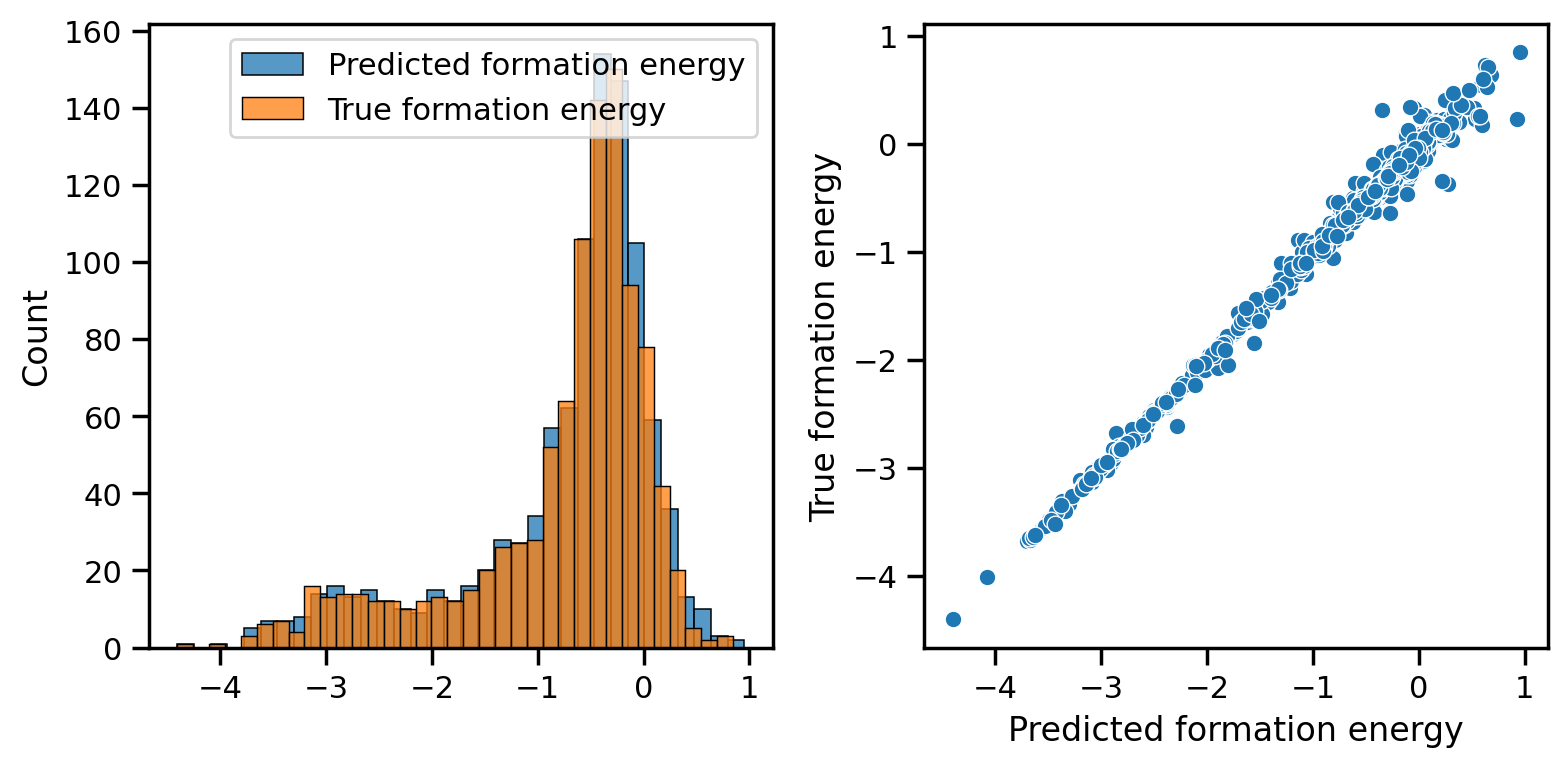

{
    'F1': 0.7486338797814208,
    'DAF': 4.210324129651861,
    'Precision': 0.8058823529411765,
    'Recall': 0.6989795918367347,
    'Accuracy': 0.91015625,
    'TPR': 0.6989795918367347,
    'FPR': 0.03985507246376811,
    'TNR': 0.9601449275362319,
    'FNR': 0.3010204081632653,
    'TP': 137,
    'FP': 33,
    'TN': 795,
    'FN': 59,
    'MAE': 0.04717272857556054,
    'RMSE': 0.08306584228303837,
    'R2': 0.9023078509417637
}

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from matbench_discovery.metrics import stable_metrics

sns.set_context("notebook")

e_form_true, e_form_pred = zip(*preds_targets["e_form"])
e_form_true = np.array(e_form_true)
e_form_pred = np.array(e_form_pred)

e_above_hull_true, e_above_hull_pred = zip(*preds_targets["e_above_hull"])
e_above_hull_true = np.array(e_above_hull_true)
e_above_hull_pred = np.array(e_above_hull_pred)

rich.print(
    {
        "e_form": {"pred": e_form_pred.shape, "true": e_form_true.shape},
        "e_above_hull": {
            "pred": e_above_hull_pred.shape,
            "true": e_above_hull_true.shape,
        },
    }
)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes = axes.flatten()

ax = axes[0]
sns.histplot(e_form_pred, label="Predicted formation energy", ax=ax)
sns.histplot(e_form_true, label="True formation energy", ax=ax)
ax.legend()

ax = axes[1]
sns.scatterplot(y=e_form_true, x=e_form_pred, ax=ax)
ax.set_xlabel("Predicted formation energy")
ax.set_ylabel("True formation energy")

fig.tight_layout()
plt.show()

metrics = stable_metrics(e_above_hull_true, e_above_hull_pred, fillna=False)
rich.print(metrics)